In [131]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchvision.transforms.v2 as v2
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Precision, Recall
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [52]:
record_path=r"C:\Users\piotr\.cache\kagglehub\datasets\nih-chest-xrays\data\versions\3"

In [53]:
# cleaning the dataframe
df=pd.read_csv(record_path+r"\Data_Entry_2017.csv")
good=["Image Index","Finding Labels"]
df=df[good]
display(df)

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia
...,...,...
112115,00030801_001.png,Mass|Pneumonia
112116,00030802_000.png,No Finding
112117,00030803_000.png,No Finding
112118,00030804_000.png,No Finding


In [54]:
# Getting all the deseases from the DF and creating one-hot encoding.
diseases=set()
for i in df["Finding Labels"].unique():
    z=i.split("|")
    for j in z:
        diseases.add(j)
print(diseases)
for i in diseases:
    df.loc[:,i]=0

for index,row in df.iterrows():
    labels= row["Finding Labels"].split("|")
    for i in labels:
        df.loc[index,i]=1
df=df.drop("Finding Labels",axis=1)
display(df)

{'Pneumothorax', 'Consolidation', 'Nodule', 'Infiltration', 'Atelectasis', 'Effusion', 'Hernia', 'Pleural_Thickening', 'Mass', 'Fibrosis', 'Emphysema', 'No Finding', 'Pneumonia', 'Cardiomegaly', 'Edema'}


,Image Index,Pneumothorax,Consolidation,Nodule,Infiltration,Atelectasis,Effusion,Hernia,Pleural_Thickening,Mass,Fibrosis,Emphysema,No Finding,Pneumonia,Cardiomegaly,Edema
0,00000001_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,00000001_001.png,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,00000001_002.png,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,00000003_000.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
112116,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
112117,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
112118,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


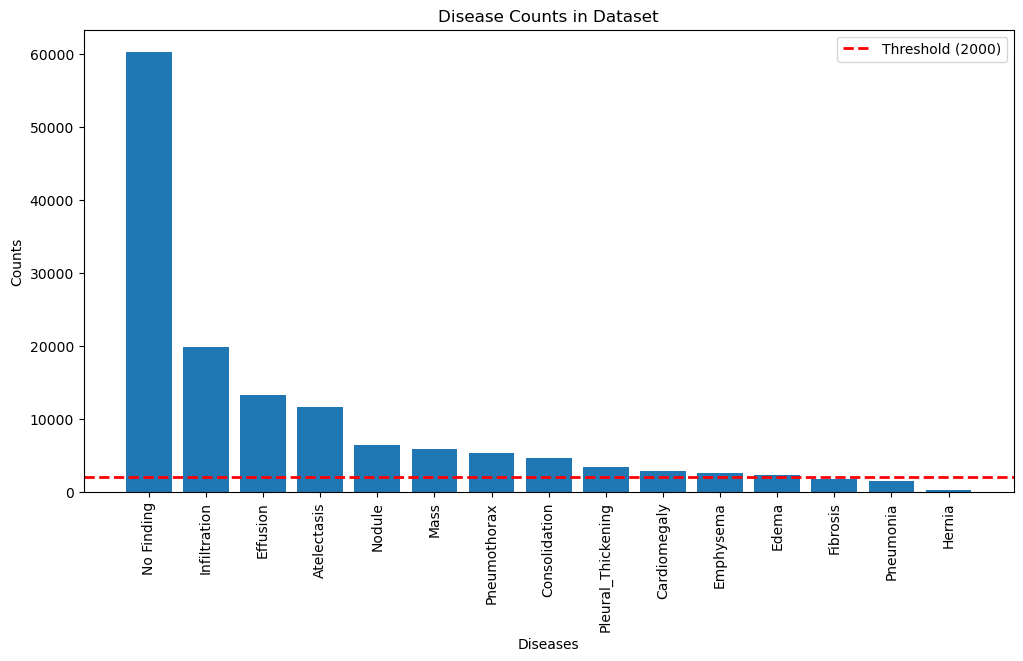

In [67]:
counts=[df[i].sum() for i in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [5]:
# # we now create the training data frame using the list provided in the files.
# image_names_train= open(r"train_val_list.txt").read().split("\n")
# for i in image_names_train:
#     df_train=df[df["Image Index"].isin(image_names_train)]
# df_train.to_parquet("df_train.parquet")

In [6]:
# # we now create the training data frame using the list provided in the files.
# image_names_test= open(r"test_list.txt").read().split("\n")
# for i in image_names_test:
#     df_test=df[df["Image Index"].isin(image_names_test)]
# df_test.to_parquet("df_test.parquet")

In [72]:
df_train=pd.read_parquet("df_train.parquet")

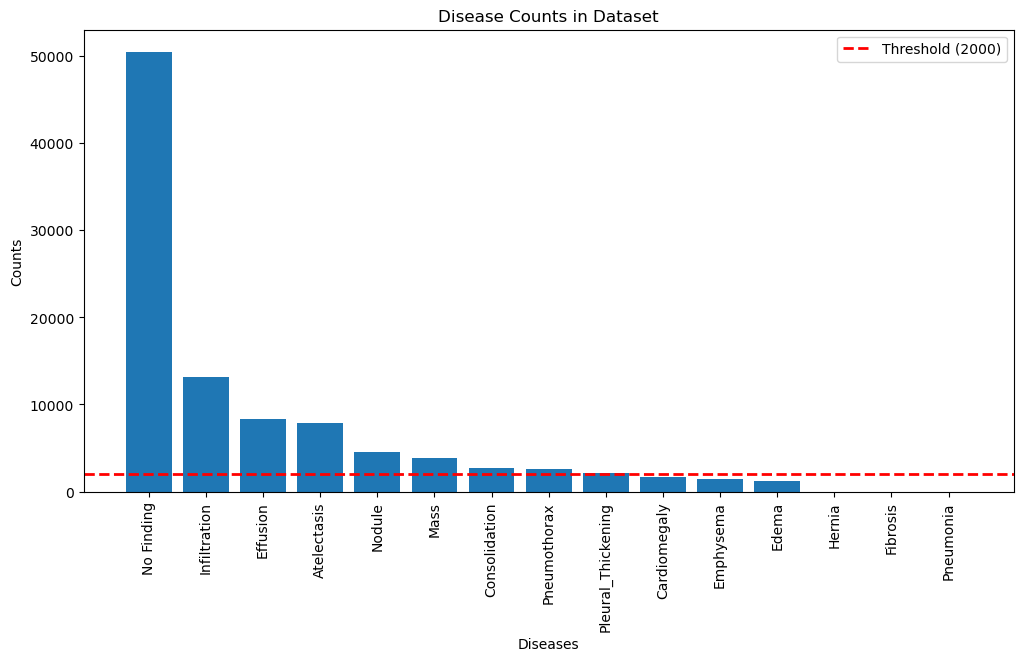

In [73]:
# We check to see how balanced the set is and check if any class is very underrepresented.
diseases=list(diseases)
counts=[df_train[i].sum() for i in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [74]:
# we remove diseases that are too rare.
rare_diseases=[i[0] for i in disease_counts if i[1]<2000]
for disease in rare_diseases:
    df_train=df_train[df_train[disease] !=1]

In [75]:
df_train=df_train[["Image Index"]+[i for i in diseases if i not in rare_diseases]]

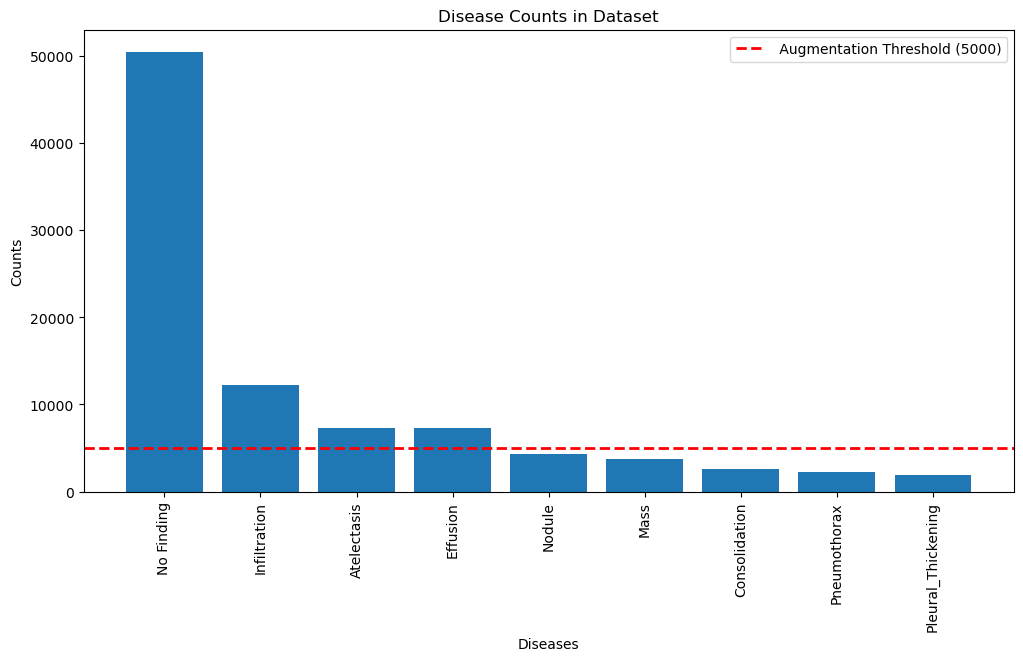

In [77]:
# We check to see how balanced the set is and check if any class is very underrepresented.
common_diseases=[i for i in diseases if i not in rare_diseases]
common_counts=[df_train[i].sum() for i in common_diseases]
common_disease_counts = sorted(zip(common_diseases, common_counts), key=lambda x: x[1], reverse=True)
sorted_common_diseases, sorted_common_counts = zip(*common_disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_common_diseases, sorted_common_counts)
plt.axhline(y=5000, color='red', linestyle='--', linewidth=2, label=' Augmentation Threshold (5000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [81]:
diseases_to_augment=[i[0] for i in common_disease_counts if i[1]<5000]

In [109]:
df_train_balanced=df_train.copy()
import random

for disease in diseases_to_augment:
    df_disease = df_train[df_train[disease] == 1]
    num_to_add = 5000 - len(df_disease)
    sampled_indices = random.choices(df_disease.index, k=num_to_add)
    df_train_balanced = pd.concat([df_train_balanced, df_train.loc[sampled_indices]])
df_train_balanced=df_train_balanced.reset_index(drop=True)

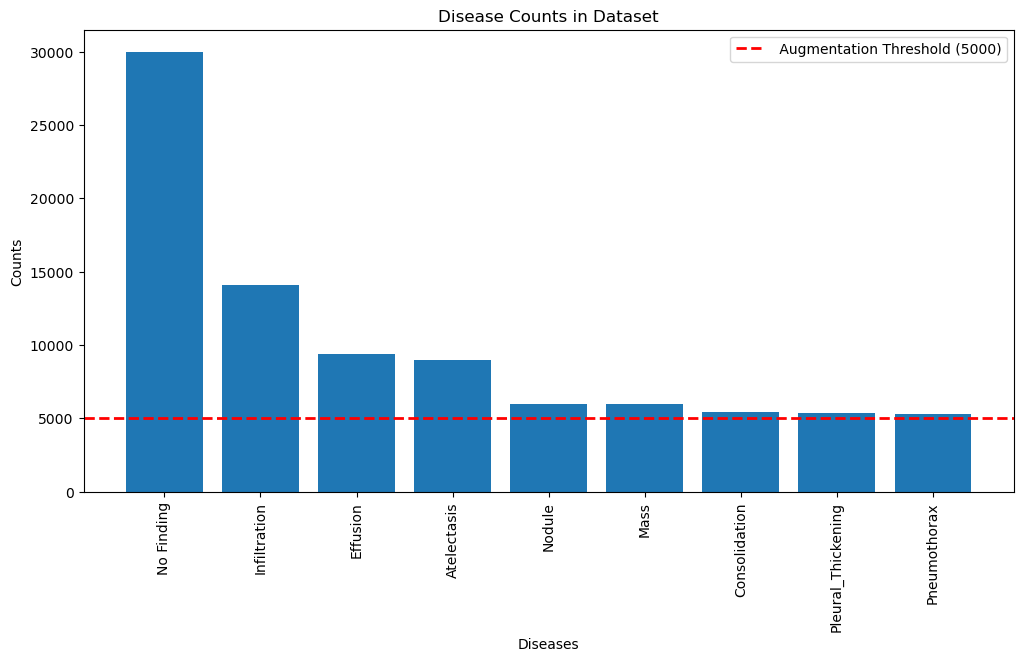

In [114]:
# We check to see how balanced the set is and check if any class is very underrepresented.
common_diseases=[i for i in diseases if i not in rare_diseases]
common_counts=[df_train_balanced[i].sum() for i in common_diseases]
common_disease_counts = sorted(zip(common_diseases, common_counts), key=lambda x: x[1], reverse=True)
sorted_common_diseases, sorted_common_counts = zip(*common_disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_common_diseases, sorted_common_counts)
plt.axhline(y=5000, color='red', linestyle='--', linewidth=2, label=' Augmentation Threshold (5000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [112]:
no_finding_samples = df_train_balanced[df_train_balanced["No Finding"] == 1]

# Undersample
undersample_size = 30000
undersampled_no_finding = no_finding_samples.sample(undersample_size, random_state=42)

# Combine with the other classes
df_train_balanced = pd.concat([
    df_train_balanced[df_train_balanced["No Finding"] == 0],  # Keep all disease samples
    undersampled_no_finding
]).reset_index(drop=True)
print(df_train_balanced.iloc[:, 1:].sum())  # Check the sum for all diseases

Pneumothorax           5309
Consolidation          5430
Nodule                 5977
Infiltration          14085
Atelectasis            8942
Effusion               9415
Pleural_Thickening     5362
Mass                   5971
No Finding            30000
dtype: int64


In [113]:
image_paths=glob.glob(record_path+r"\**\*.png",recursive=True)

In [124]:
image_path_dict = {path.split("\\")[-1]: path for path in image_paths}

class XrayDataset(Dataset):
    def __init__(self, df, image_path_dict, transform=None):
        self.df = df
        self.image_path_dict = image_path_dict  # Dictionary for quick lookup
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['Image Index']
        image_path = self.image_path_dict[image_name]
        if image_path is None:
            raise FileNotFoundError(f"Image {image_name} not found.")
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx].iloc[1:].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

#Data Augmentation transform
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
    v2.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=10),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.1, contrast=0.1),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [129]:

# Split the training dataset into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df_train_balanced, test_size=0.2, random_state=42)
# Create new datasets for training and validation
train_dataset = XrayDataset(train_df, image_path_dict, transform=transform)
val_dataset = XrayDataset(val_df, image_path_dict, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,pin_memory=True)

In [ ]:

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup (DenseNet example)
num_classes = 9
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)  # Modify for multi-label classification
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create the trainer and evaluators
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

val_metrics = {
    "accuracy": Accuracy(output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1])),  # Multi-label accuracy
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

# Attach progress bar to the trainer
pbar = ProgressBar(persist=True)
pbar.attach(trainer, output_transform=lambda x: {"loss": x})

# Validation after each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    print(f"\nValidation Results - Epoch: {engine.state.epoch}  Avg accuracy: {metrics['accuracy']:.4f}  Avg loss: {metrics['loss']:.4f}")



c:\Users\piotr\anaconda3\Lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[1/3490]   0%|           [00:00<?]


Validation Results - Epoch: 1  Avg accuracy: 0.8655  Avg loss: 0.3492


State:
	iteration: 3490
	epoch: 1
	epoch_length: 3490
	max_epochs: 1
	output: 0.305650232265694
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [135]:
trainer.run(train_loader, max_epochs=10)

[1/3490]   0%|           [00:00<?]


Validation Results - Epoch: 2  Avg accuracy: 0.8621  Avg loss: 0.3567


[1/3490]   0%|           [00:00<?]


Validation Results - Epoch: 3  Avg accuracy: 0.8704  Avg loss: 0.3302


[1/3490]   0%|           [00:00<?]


Validation Results - Epoch: 4  Avg accuracy: 0.8715  Avg loss: 0.3273


[1/3490]   0%|           [00:00<?]


Validation Results - Epoch: 5  Avg accuracy: 0.8725  Avg loss: 0.3210


[1/3490]   0%|           [00:00<?]


Validation Results - Epoch: 6  Avg accuracy: 0.8718  Avg loss: 0.3241


[1/3490]   0%|           [00:00<?]


Validation Results - Epoch: 7  Avg accuracy: 0.8737  Avg loss: 0.3173


[1/3490]   0%|           [00:00<?]


Validation Results - Epoch: 8  Avg accuracy: 0.8742  Avg loss: 0.3168


[1/3490]   0%|           [00:00<?]


Validation Results - Epoch: 9  Avg accuracy: 0.8736  Avg loss: 0.3157


[1/3490]   0%|           [00:00<?]


Validation Results - Epoch: 10  Avg accuracy: 0.8746  Avg loss: 0.3134


State:
	iteration: 34900
	epoch: 10
	epoch_length: 3490
	max_epochs: 10
	output: 0.32752201442766676
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [136]:
df_test=pd.read_parquet("df_test.parquet")
df_test=df_test[["Image Index"]+[i for i in diseases if i not in rare_diseases]]
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)
all_preds = []
all_labels = []

def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        # Add this print to check if it's running

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    return outputs, labels
evaluator = Engine(evaluate_step)
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Run evaluation on test data
evaluator.run(test_loader)

# Concatenate all predictions and labels
y_pred = np.concatenate(all_preds, axis=0)
y_true = np.concatenate(all_labels, axis=0)


# Compute detailed metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(y_true.shape[1])]))

# Optional: Confusion Matrix
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print("\nConfusion Matrix:\n", cm)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.41      0.25      0.31      2590
     Class 1       0.22      0.01      0.02      1724
     Class 2       0.41      0.06      0.10      1544
     Class 3       0.43      0.23      0.30      5759
     Class 4       0.47      0.11      0.18      3150
     Class 5       0.54      0.28      0.37      4501
     Class 6       0.21      0.06      0.10      1060
     Class 7       0.37      0.23      0.29      1667
     Class 8       0.73      0.39      0.51      9861

   micro avg       0.54      0.25      0.34     31856
   macro avg       0.42      0.18      0.24     31856
weighted avg       0.52      0.25      0.33     31856
 samples avg       0.31      0.27      0.28     31856


Confusion Matrix:
 [[2401    6   51  326   58  180   53   98  302]
 [ 807   19   11  346   80  225    9   55   59]
 [ 587    1   66  173   22   87    6   97  206]
 [2236   21   24  981  150  357   19  103  476]
 [ 84

c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


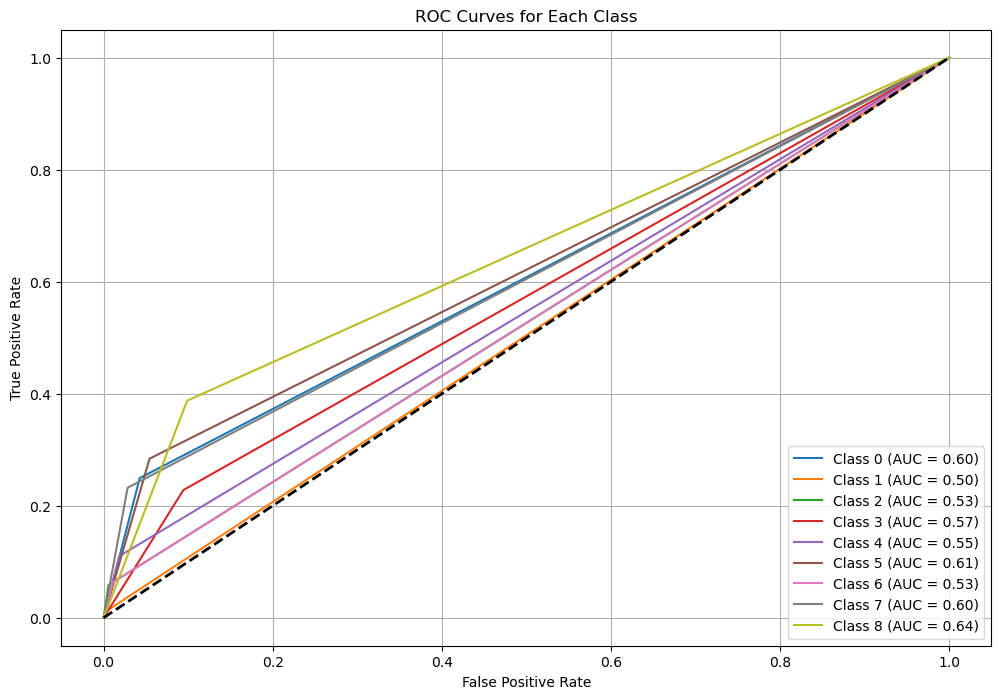

In [141]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Concatenate all predictions and labels (replace with your actual data)
y_true = np.concatenate(all_labels, axis=0).astype(int)  # True labels
y_pred = np.concatenate(all_preds, axis=0).astype(int)  # Predicted probabilities

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(y_true.shape[1]):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
df_test=pd.read_parquet("df_test.parquet")
df_test=df_test[["Image Index"]+[i for i in diseases if i not in rare_diseases]]
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)
all_preds = []
all_labels = []

def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        # Add this print to check if it's running

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    return outputs, labels
evaluator = Engine(evaluate_step)
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# Run evaluation on test data
evaluator.run(test_loader)

# Concatenate all predictions and labels
y_pred = np.concatenate(all_preds, axis=0)
y_true = np.concatenate(all_labels, axis=0)

# Reset for future use
all_preds, all_labels = [], []

# Compute detailed metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(y_true.shape[1])]))

# Optional: Confusion Matrix
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print("\nConfusion Matrix:\n", cm)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.25      0.00      0.01      2590
     Class 1       0.00      0.00      0.00      1724
     Class 2       0.05      0.25      0.08      1544
     Class 3       0.45      0.10      0.16      5759
     Class 4       0.12      0.00      0.00      3150
     Class 5       0.38      0.01      0.01      4501
     Class 6       0.05      0.06      0.05      1060
     Class 7       0.43      0.06      0.11      1667
     Class 8       0.18      0.00      0.00      9861

   micro avg       0.11      0.04      0.05     31856
   macro avg       0.21      0.05      0.05     31856
weighted avg       0.25      0.04      0.04     31856
 samples avg       0.05      0.03      0.04     31856


Confusion Matrix:
 [[2544    0  676  108    6    6   96   39    0]
 [1134    0  142  136    0    5  186    8    0]
 [ 701    0  349   89    2    3   58   43    0]
 [2779    0  824  425    1   13  309   16    0]
 [ 91

c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
df_test=pd.read_parquet("df_test.parquet")
df_test=df_test[["Image Index"]+[i for i in diseases if i not in rare_diseases]]
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)
evaluator.run(test_loader)
evaluator.state.metrics


{'val_loss': 0.33833323564788387,
 'accuracy': 0.8669575144744353,
 'precision': 0.6151781582600648,
 'Recall': 0.2086577096936213}

In [33]:
torch.cuda.empty_cache()

In [34]:
import gc

In [35]:
gc.collect()

0

In [30]:
model = models.densenet121(pretrained=False, num_classes=9)  # Ensure the architecture matches
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode

c:\Users\piotr\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\piotr\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [144]:
torch.save(model.state_dict(),"Model, Epochs of 10 data augmentation and upsampling")